In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns
import plotly.express as px
import hdbscan
import viz
from matplotlib import use

In [26]:
def read_df_json(f):
    df = pd.read_json(f, orient='records')
    df = df.explode('xyzv')
    df['x'] = df.apply(lambda r: r.xyzv[0], axis=1)
    df['y'] = df.apply(lambda r: r.xyzv[1], axis=1)
    df['z'] = df.apply(lambda r: r.xyzv[2], axis=1)
    df['v'] = df.apply(lambda r: r.xyzv[3], axis=1)
    df['ts'] = pd.to_datetime(df['ts'] / 1000, unit='s')
    df = df.drop('xyzv', axis=1)
    df = df.reset_index(drop=True)
    df = df.rename({'idx':'frame'}, axis=1)
    return df

In [27]:
# Make single dataframe from readings
df1 = read_df_json('data/bball_part1_behind_bat.json')
df2 = read_df_json('data/bball_part2.json')
df0 = pd.concat([df1.assign(behind_bball=True),df2.assign(behind_bball=False)]).reset_index(drop=True)

# Fix/Simplify precision of timestamp
df1['ts'] = df1['ts'].dt.floor('us')
df2['ts'] = df2['ts'].dt.floor('us')
df0['ts'] = df0['ts'].dt.floor('us')

In [29]:
def make_stacked_df(df: pd.DataFrame, stack_size: int):
    """
    df (DataFrame):     dataframe
    stack_size (int):   frames in stack
    """

    df = df.copy(deep=True)
    ts = pd.Series(df['ts'].unique(), name='timestamps')
    stacknum = 0
    df_new = pd.DataFrame()

    for t_idx in ts.index:
        g = df.loc[df.ts.isin(ts.loc[t_idx:(t_idx + stack_size - 1)])]
        g = g.loc[g.frame >= g.frame.iloc[0]]
        g['stack'] = stacknum
        df_new = pd.concat([df_new,g])
        stacknum += 1
    
    return df_new

In [33]:
# Commented out bc this is slow
#df = make_stacked_df(df0, 20)

In [31]:
df0.to_csv("data/data_unstacked.csv", index=False)
#df.to_csv("data/data_stack_20.csv", index=False)
df.to_parquet("data/data_stack_20.parquet", compression='gzip')

## visualizing

In [3]:
# RELOAD DATA
df0 =  pd.read_csv("data/data_unstacked.csv")
df = pd.read_parquet("data/data_stack_20.parquet")
#df_ = pd.read_parquet("data/tmp.parquet")

In [ ]:
viz.viz1(df[:1_500], 'vel')
#viz.viz3(df[:100_000], 'v', 'v', anim_frame='stack')
#viz.viz3(df_[:10_000], 'outlier', 'clstr', anim_frame='stack', SAVE='gif')

## clustering

using hdbscan instead of scikit-learn dbscan

In [ ]:
# SCIKIT-LEARN TEST
#dbscan = DBSCAN(eps=0.5)
#cluster = dbscan.fit(g[['x','y','z','v']])
#cluster.labels_

In [ ]:
# PROOF OF CONCPT
#g = dff.loc[dff['stack'].iloc[0] == dff['stack']][['x','y','z','v']]
#scan = hdbscan.HDBSCAN(min_cluster_size=2, algorithm='best', alpha=1.0, metric='euclidean')
#labels = scan.fit().labels_
#g.assign(clstr=labels)

In [74]:
def do_hdbscan(df_in: pd.DataFrame) -> pd.DataFrame:
    
    df_out = pd.DataFrame()
    df_in = df_in.copy(deep=True)

    df_in['v'] = df_in['v'].abs()
    scan = hdbscan.HDBSCAN(min_cluster_size=3, algorithm='best', alpha=1.0, metric='euclidean')
    for stack,g in df_in.groupby('stack'):
        df_tmp = g.copy(deep=True)
        labels = scan.fit(df_tmp[['x','y','z','v']]).labels_
        df_tmp = df_tmp.assign(clstr=labels)
        df_out = pd.concat([df_out, df_tmp])

    return df_out

In [131]:
def do_hdbscan_outliers(df_in: pd.DataFrame) -> pd.DataFrame:
    
    df_out = pd.DataFrame()
    df_in = df_in.copy(deep=True)
    df_in['v'] = df_in['v'].abs()
    
    scan = hdbscan.HDBSCAN(min_cluster_size=3, algorithm='best', alpha=1.0, metric='euclidean')
    for stack,g in df_in.groupby('stack'):
        df_tmp = g.copy(deep=True)
        model = scan.fit(df_tmp[['x','y','z','v']])
        df_tmp = df_tmp.assign(clstr=model.outlier_scores_)
        df_out = pd.concat([df_out, df_tmp])

    return df_out

In [133]:
dff = df[:10_000]
scan = hdbscan.HDBSCAN(min_cluster_size=3, algorithm='best', alpha=1.0, metric='euclidean')
model = scan.fit(dff[['x','y','z','v']])
dff.assign(xxx=model.outlier_scores_)

In [8]:
def find_outliers(df_in: pd.DataFrame, /, stack_col: str = 'stack', do_absval: bool = True, MIN_CLSTR_SIZE: int = 3):
    from warnings import filterwarnings
    filterwarnings('ignore', category=RuntimeWarning)

    df_in = df_in.copy(deep=True)
    df_out = pd.DataFrame()

    if do_absval:
        df_in['v'] = df_in['v'].abs()

    # scan = hdbscan.HDBSCAN(min_cluster_size=3, algorithm='best', alpha=1.0, metric='euclidean')
    cols = ['x','y','z','v']

    for stack,g in df_in.groupby(stack_col):
        
        if len(g) <= MIN_CLSTR_SIZE+2:
            print(f"WARNING: Length = {len(g)}, stack = {stack}, frame = {g['frame'].min()} -- Not enough points")
        
        else:        
            scan = hdbscan.HDBSCAN(min_cluster_size=MIN_CLSTR_SIZE, algorithm='best', alpha=1.0, metric='euclidean')
            g = g.copy(deep=True)
            #print(f"Length of g[{stack}] = {len(g)}")
            model = scan.fit(g[cols])
            g = g.assign(outlier=model.outlier_scores_, clstr=model.labels_)
            df_out = pd.concat([df_out, g])
    
    return df_out

In [375]:
df_ = find_outliers(df, do_absval=True)

In [9]:
df__ = df_.loc[((df_['outlier'] >= 0.95) & (df_['v'] >= 1))]
df__

,frame,ts,x,y,z,v,behind_bball,stack,outlier,clstr
780,241,2023-02-16 20:02:42.260999,0.494467,1.687139,0.0,2.739372,True,239,0.958241,-1
780,241,2023-02-16 20:02:42.260999,0.494467,1.687139,0.0,2.739372,True,240,0.958241,-1
887,269,2023-02-16 20:02:43.194000,-0.297596,1.881221,0.0,4.382995,True,250,0.966343,-1
881,268,2023-02-16 20:02:43.160999,-1.172071,2.030086,0.0,7.670240,True,251,0.972772,-1
886,269,2023-02-16 20:02:43.194000,-1.025562,1.776325,0.0,8.218115,True,251,0.976259,-1
...,...,...,...,...,...,...,...,...,...,...
70229,6290,2023-02-16 20:20:10.641999,-0.412056,1.405949,0.0,2.191497,False,21730,0.954974,0
70229,6290,2023-02-16 20:20:10.641999,-0.412056,1.405949,0.0,2.191497,False,21731,0.954974,0
70229,6290,2023-02-16 20:20:10.641999,-0.412056,1.405949,0.0,2.191497,False,21732,0.954974,0
70229,6290,2023-02-16 20:20:10.641999,-0.412056,1.405949,0.0,2.191497,False,21733,0.954974,0


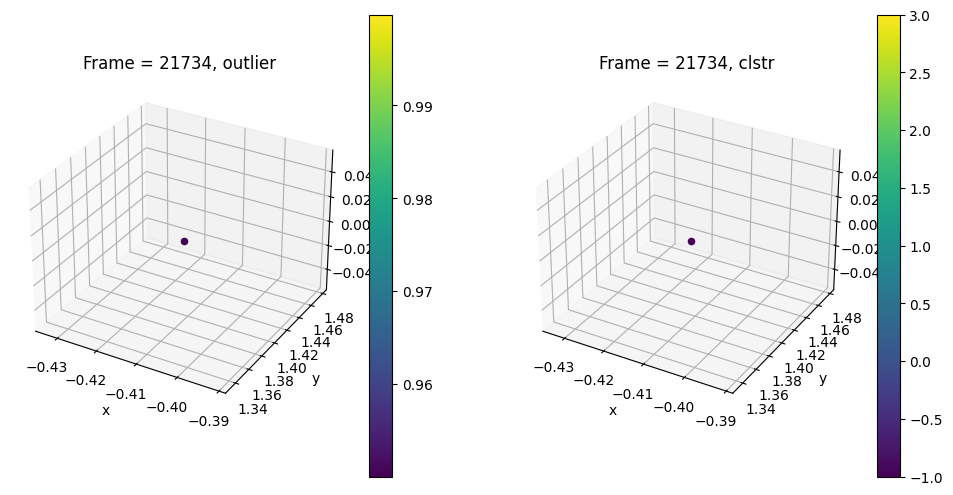

In [10]:
viz.viz3(df__, 'outlier', 'clstr', anim_frame='stack', SAVE='x265')

In [ ]:
viz.viz1(do_hdbscan(dff[2000:4000]),'3d')

## testing with velocity comparison

In [11]:
# Useful for making the DF smaller due to an abundance of stack-overlap in frames
def get_df_suspect_frames(df_in: pd.DataFrame, TST_VEL: int|float, N_STACKS: int = 5):
    df_out = df_in.copy(deep=True)    
    # Id all rows above threshold
    rows_over_Vms = df_out.loc[df_out['v'].abs() >= TST_VEL].copy()
    # Separate stacks from ID'd rows
    over_Vms_stacks = rows_over_Vms['stack'].unique()
    # Parse DF to include stacks in ID'd list
    df_out = df_out.loc[df_out['stack'].isin(over_Vms_stacks)]
    # Only include the first N stacks for each frame that has a threshold velocity
    f_stacks = df_out.loc[df_out['v'].abs() >= TST_VEL][['frame','stack']].drop_duplicates()
    N_f_stacks = f_stacks.groupby('frame').apply(lambda x: x.iloc[:N_STACKS]).reset_index(drop=True)['stack'].unique()
    # Filter DF again
    df_out = df_out.loc[df_out['stack'].isin(N_f_stacks)]
    return df_out

In [22]:
df_tst = get_df_suspect_frames(df, 15, 1)
df_tst_ = find_outliers(df_tst)

In [26]:
# YIKES homies.
px.scatter(df_tst_[df_tst_.v >= 3], x='outlier', y='v')

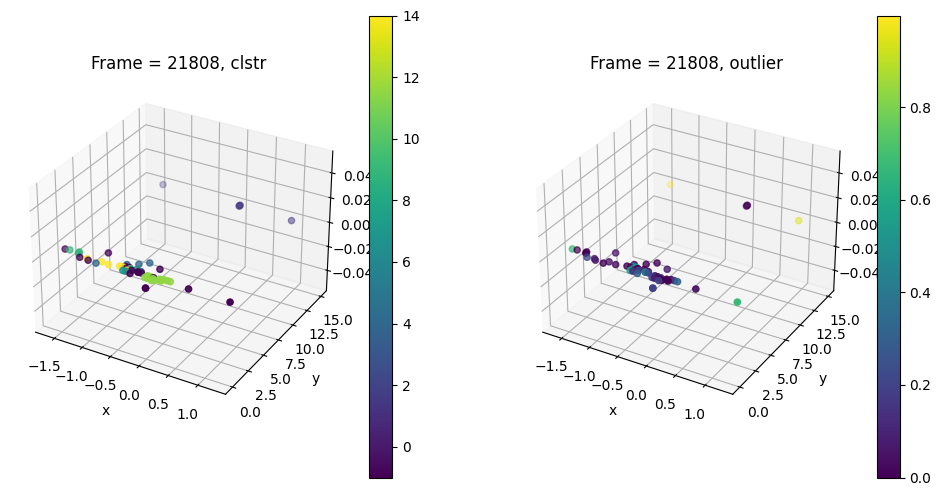

In [18]:
viz.viz3(df_tst_, 'clstr', 'outlier', SAVE='gif')

In [20]:
viz.viz1(df_tst_[:1000],'vel')

NameError: name 'dff_tst_' is not defined

In [373]:
TST_VEL = 15
total_tst_stacks = len(df_tst['stack'].unique())
total_stacks = len(dff['stack'].unique())
pct_tst_stacks = total_tst_stacks / total_stacks
print(f"Percent stack overlap with v>{TST_VEL} m/s:  {pct_tst_stacks:.2%}")

Percent stack overlap with v>15 m/s:  29.48%
